### Загрузка, исследование, подготовка временного ряда
#### Ресторан 01

In [1]:
res_name = "restaurant_01"

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import Handlers as hd

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_palette('flare')

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

In [4]:
df = pd.read_csv(f"../data/{res_name}_ts.csv", index_col=0, parse_dates=[0])
df.index.freq = "D"
df

,Orders
2019-06-10,1.0
2019-06-11,14.0
2019-06-12,332.0
2019-06-13,770.0
2019-06-14,840.0
...,...
2023-07-27,2060.0
2023-07-28,2051.0
2023-07-29,1488.0
2023-07-30,2196.0


### Очистка от выбросов, выколотых точек

### Исследование выбросов в данных

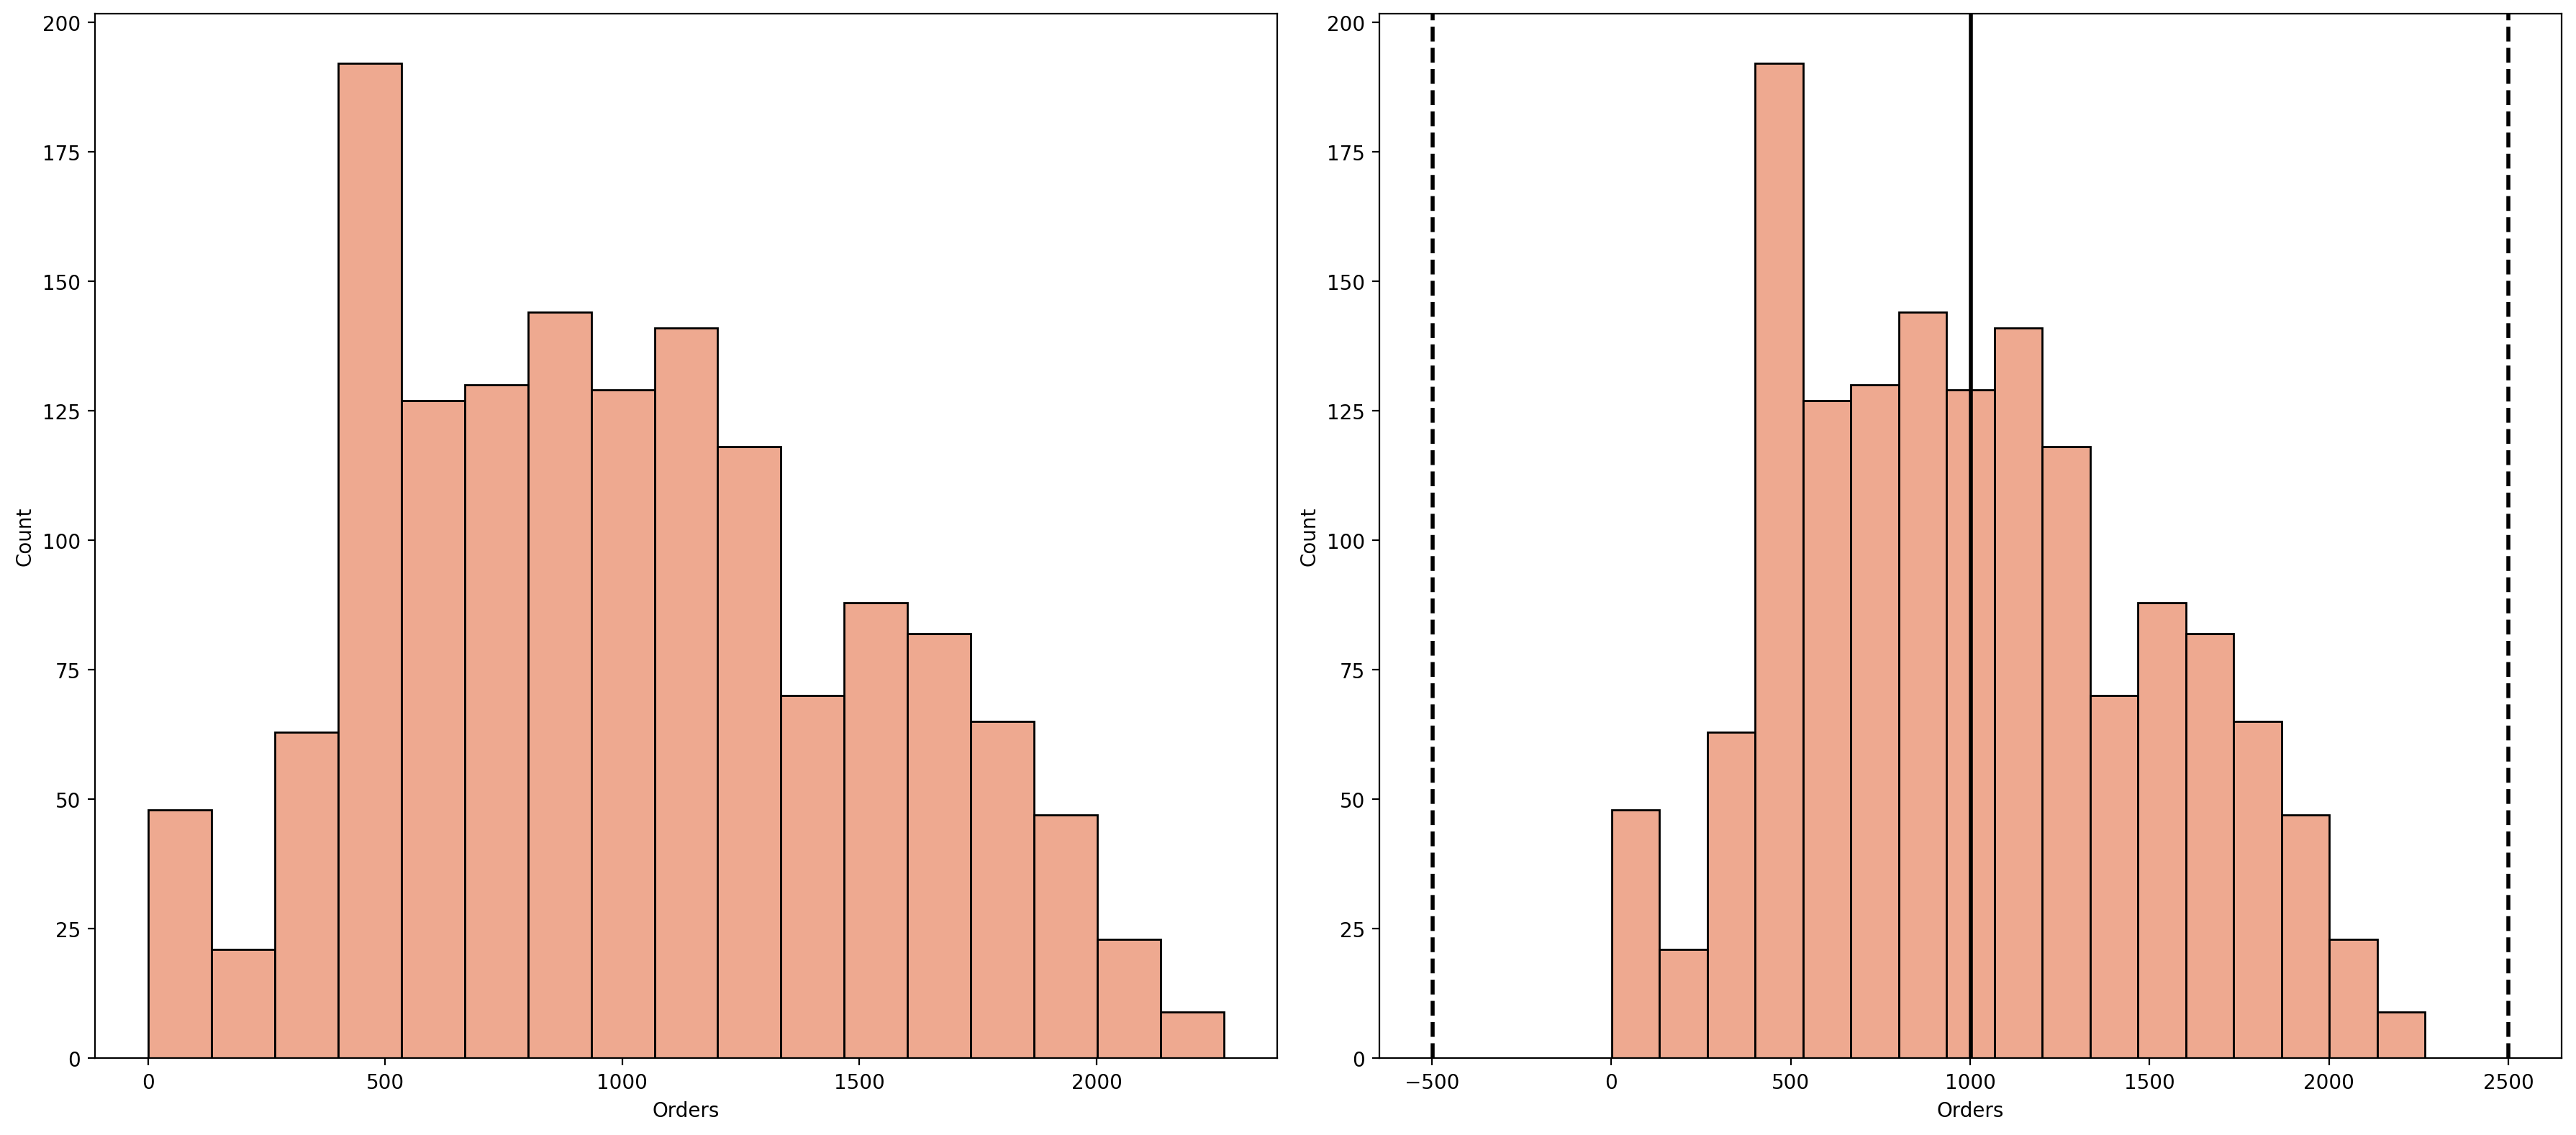

In [5]:
hd.plot_outliers_z_score(df, "Orders")

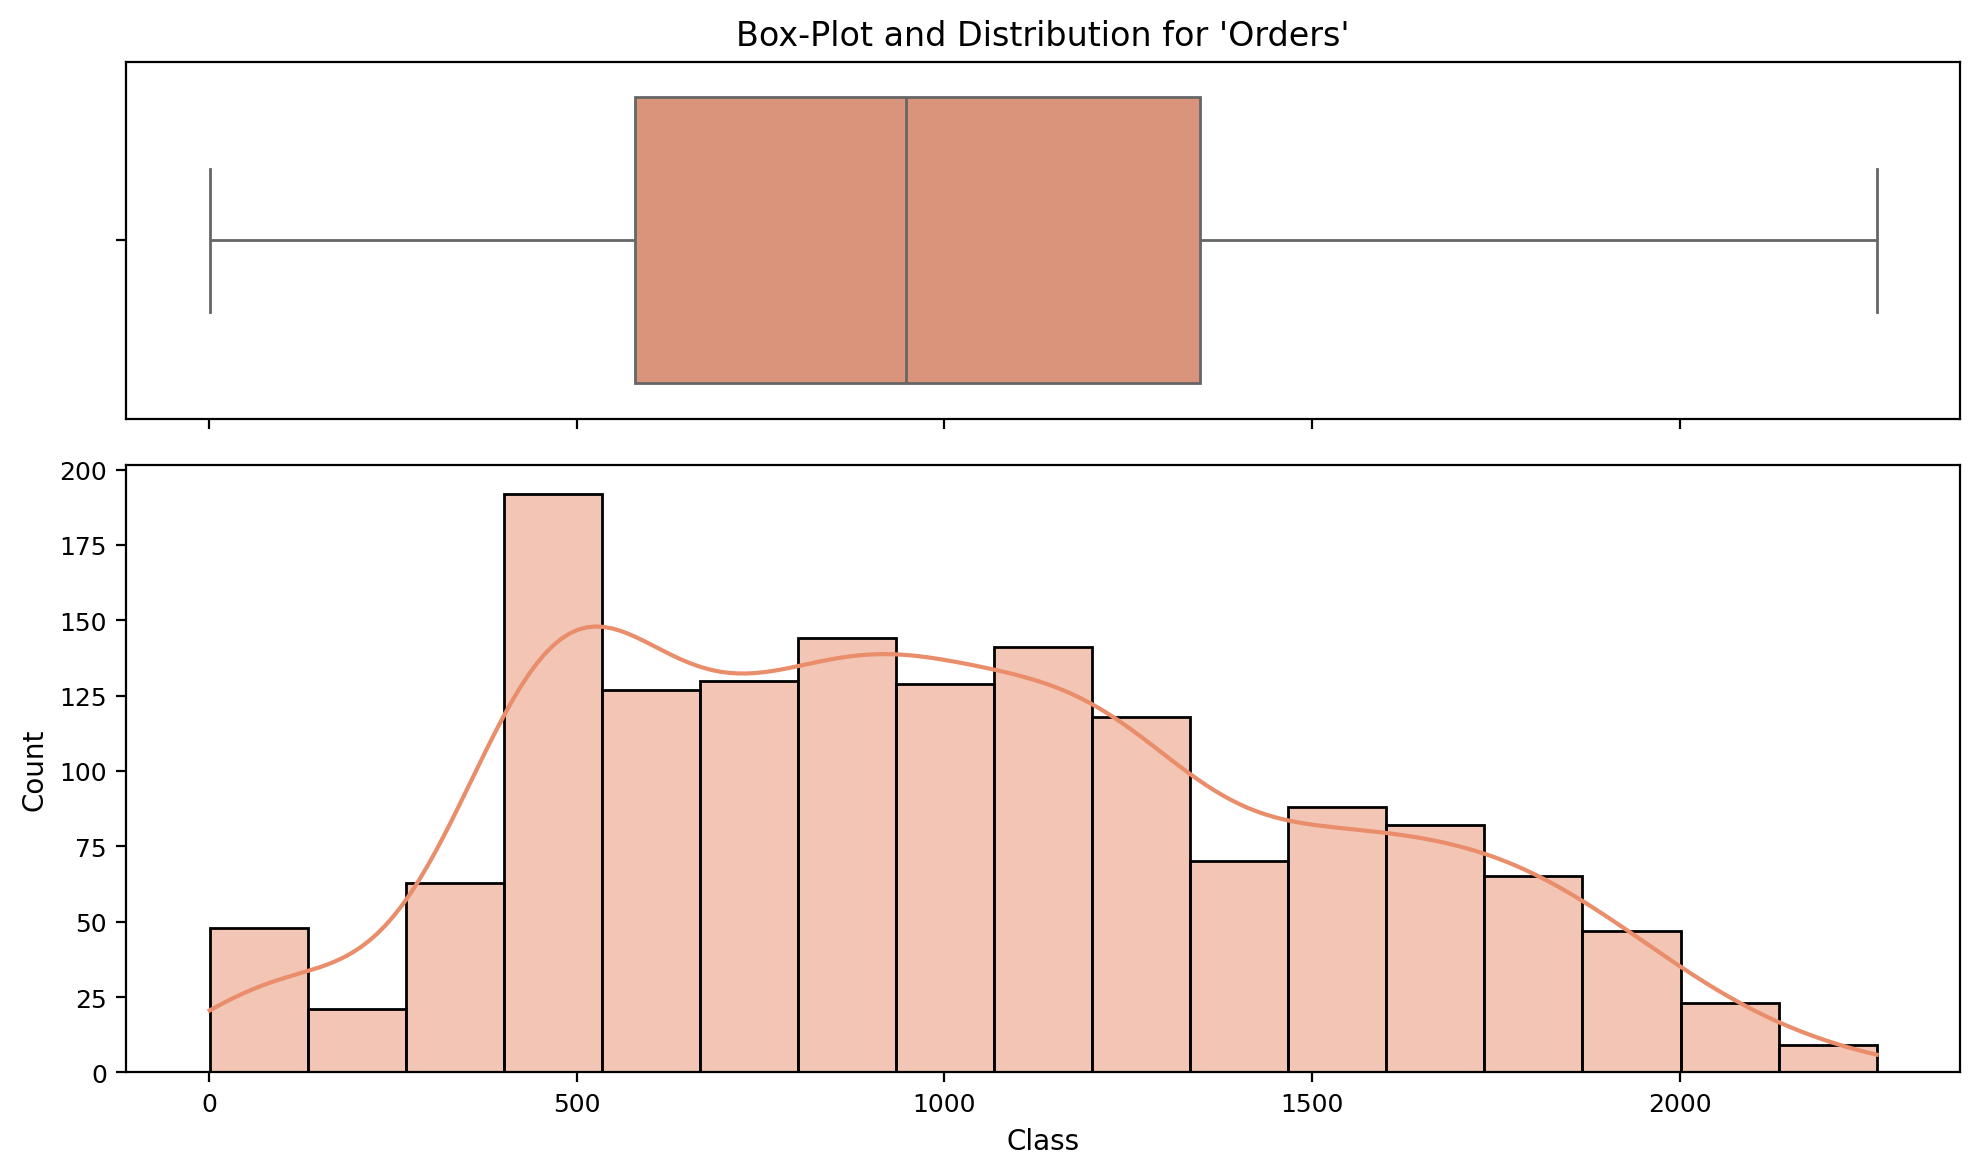

In [6]:
hd.box_and_hist_plots(df, "Orders")

Не вижу явных выбросов, которые необходимо было бы обрабатывать.

### Заполнение пропусков

In [7]:
# Пропущенные дни
na = df.isna().any(axis=1)
na_ind = na[na].index
na_ind

DatetimeIndex(['2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12'],
              dtype='datetime64[ns]', freq='D')

In [8]:
print(f"Нет данных о заказах по {len(na_ind)} дням.")

Нет данных о заказах по 16 дням.


Заполняю пропуски линейной интерполяцией

In [9]:
df["Orders"].interpolate(method="linear", inplace=True)
# преобразую количество заказов к целому типу
df["Orders"] = df["Orders"].astype(int)

Визуализация результатов заполнения пропусков

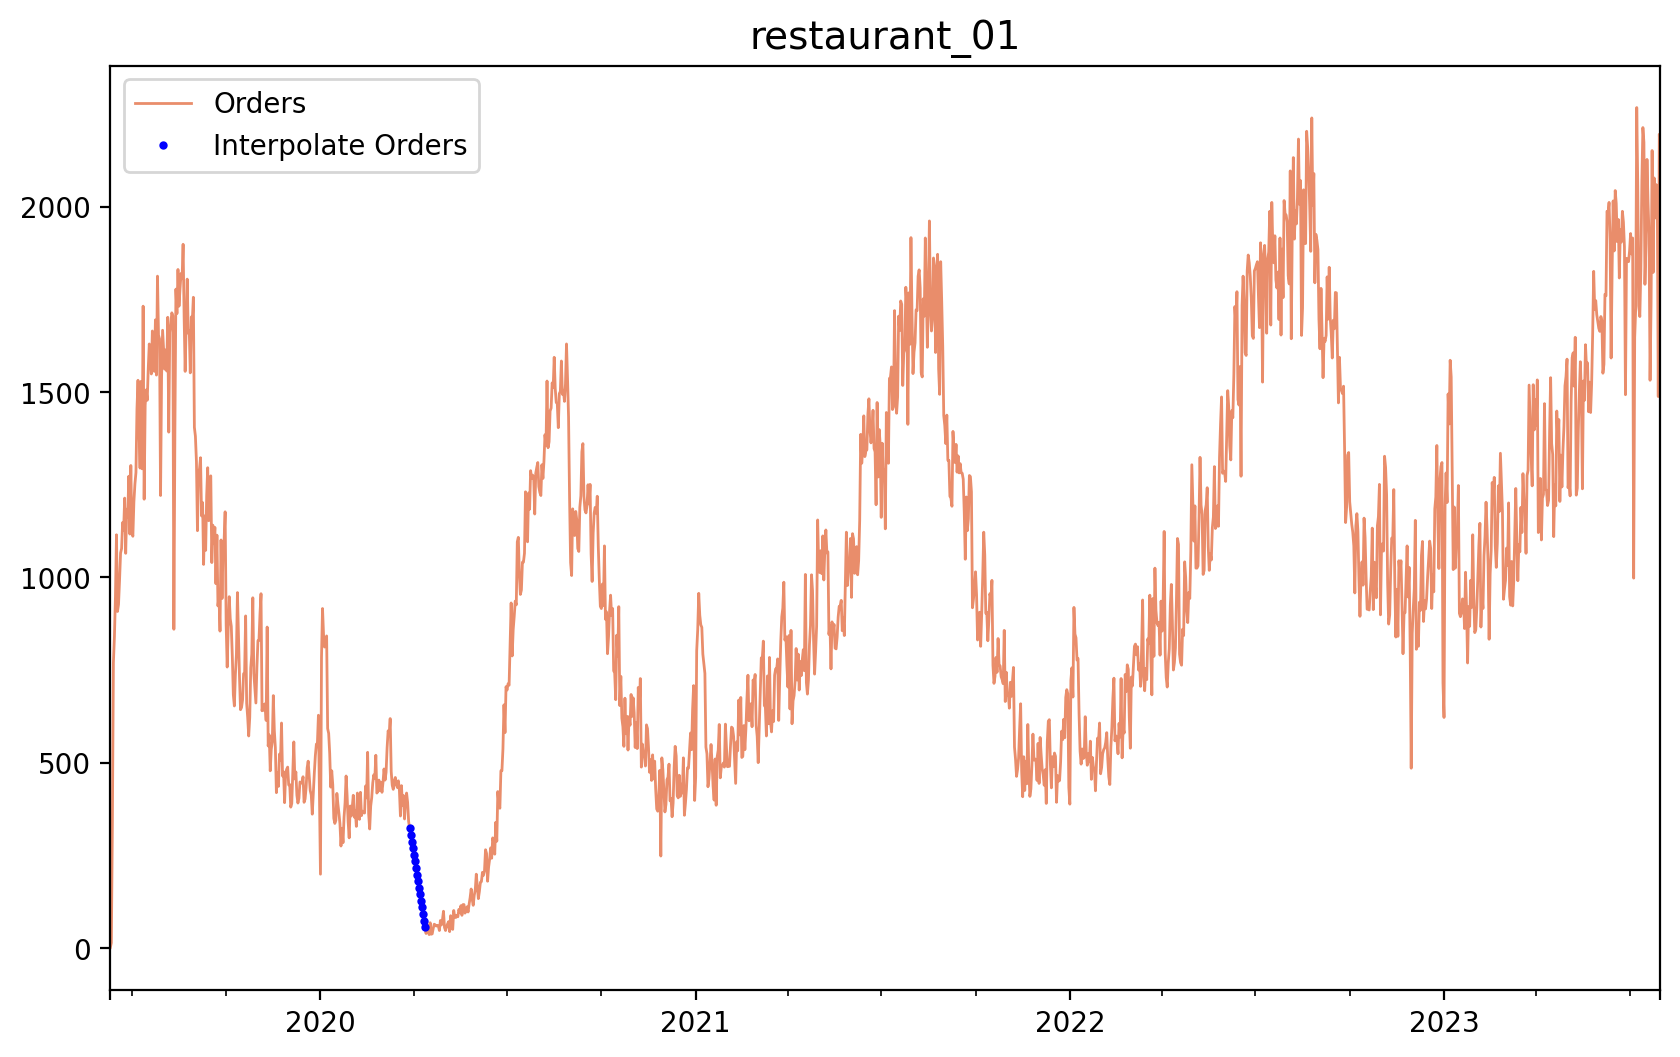

In [10]:
hd.plot_result_of_fillna(df, na_ind, res_name)

### Декомпозиция временного ряда
(тренд, сезонность внутри года, сезонность внутри недели, шум)

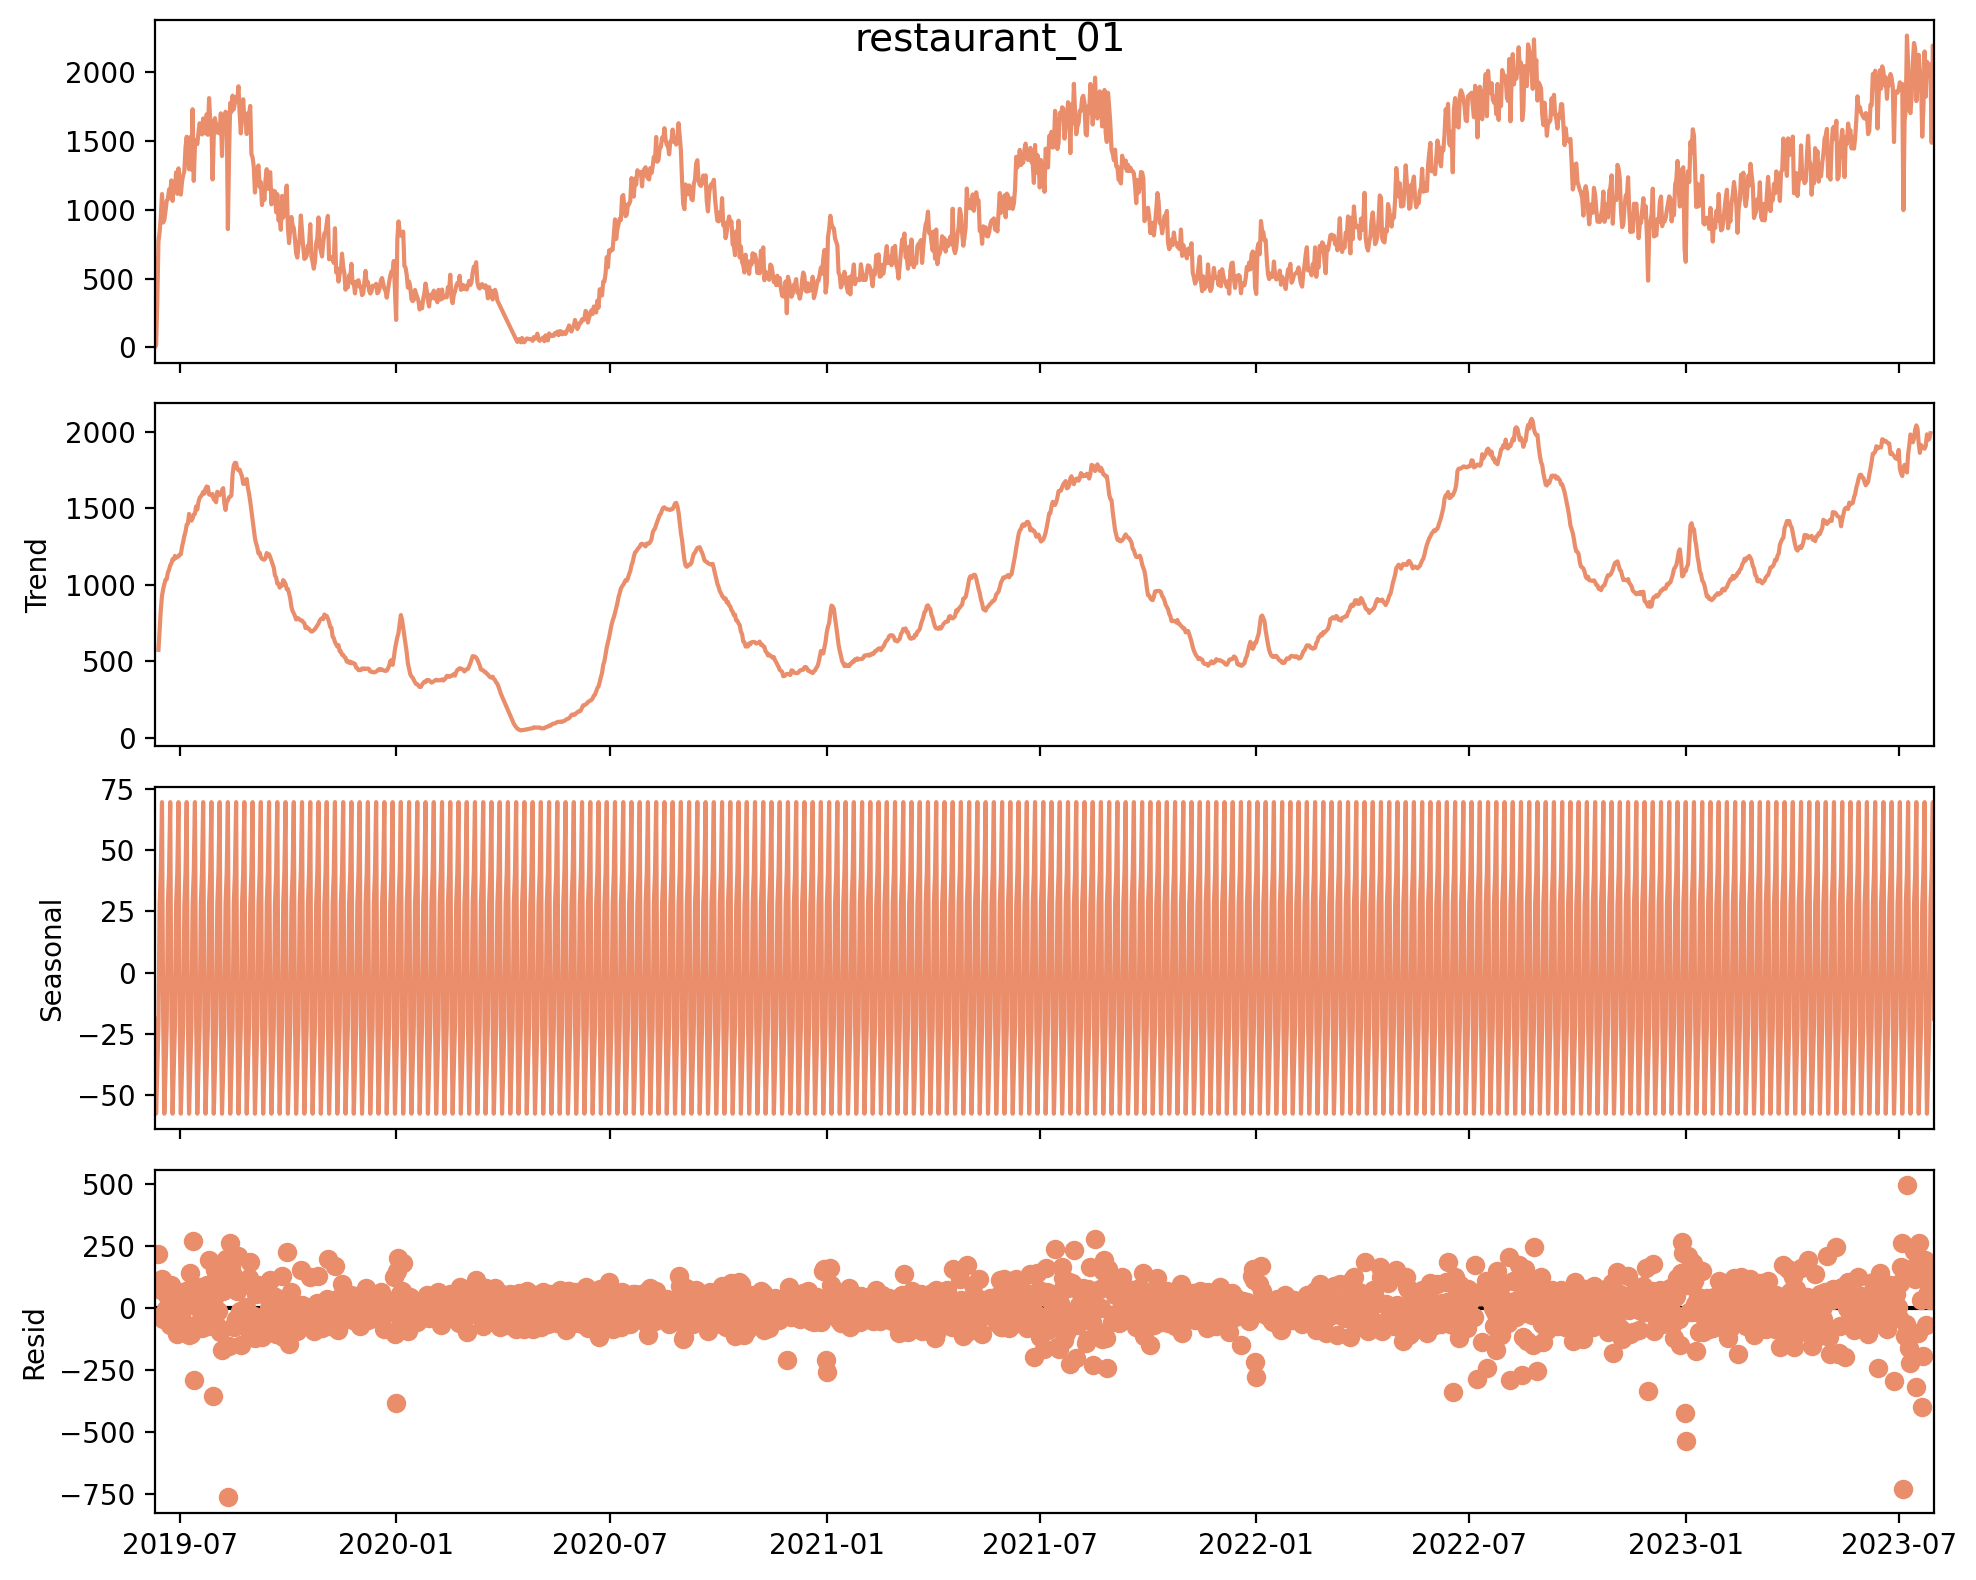

In [11]:
decomposition = seasonal_decompose(df, model="additive")
decomposition.plot()
plt.gcf().suptitle(res_name, fontsize=14)
plt.savefig("../pics/" + res_name + " decomposition.png", dpi=300, bbox_inches='tight')
plt.show()

Рассматриваю сезонную компоненту

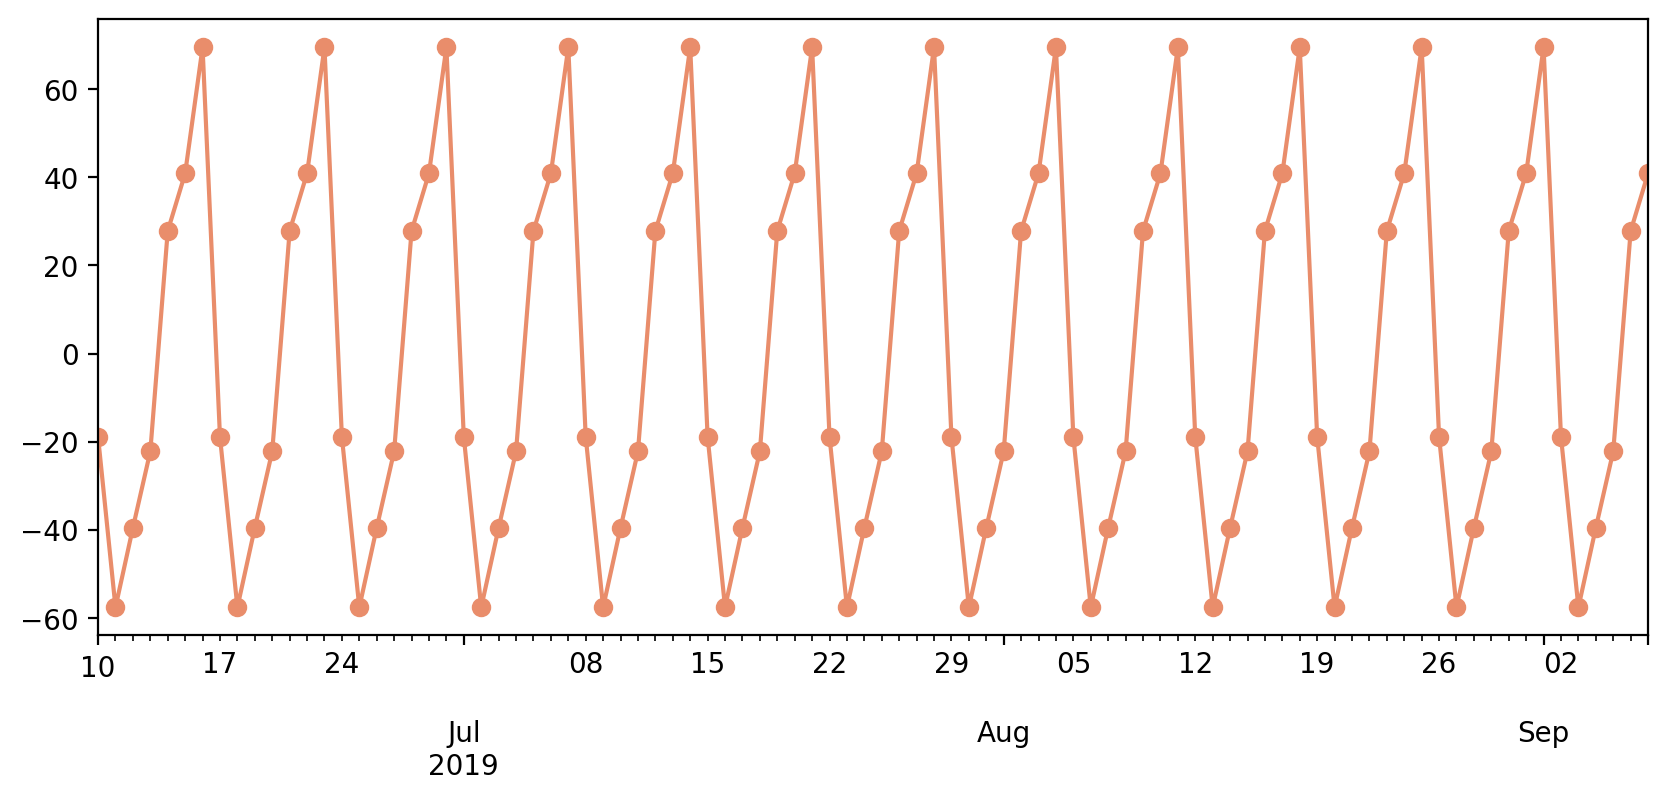

In [12]:
plt.figure(figsize=(10, 4))
decomposition.seasonal[:90].plot(marker="o")
plt.show()

График четко показывает 7 дневный (недельный) цикл сезонности.

### Прогнозирование временных рядов
- до 31.12.2023 - обязательно
- до 31.12.2024 - опционально

Определяю количество дней для будущих прогнозов

In [13]:
date1 = df.index[-1]
date2 = pd.to_datetime("2023-12-31")
date3 = pd.to_datetime("2024-12-31")

days_to_pred_2023 = (date2 - date1).days
days_to_pred_2024 = (date3 - date1).days

Использую Пророка для прогнозирования

In [14]:
# Преобразование временного ряда в необходимый пророку формат
proh_df = hd.transform_for_prophet(df)

В качестве дополнительной информации использую данные календаря

In [15]:
calendar_df = pd.read_csv("../data/calendar_ts.csv", parse_dates=["day_id"])
# Загружаю события (праздники, теплое время года, черная пятница) в датафрейм пригодный для пророка 
all_events = hd.get_events_from_calendar(calendar_df)

Предсказание до конца 2023 года

In [101]:
m = Prophet(changepoint_prior_scale=0.005, weekly_seasonality=False, holidays=all_events)
m.add_seasonality(name='custom_weekly', period=7, fourier_order=3)
m.fit(proh_df)
future = m.make_future_dataframe(periods=days_to_pred_2023, include_history=False)
forecast = m.predict(future)

pred2023 = hd.get_format_forcast(forecast)

00:58:10 - cmdstanpy - INFO - Chain [1] start processing
00:58:10 - cmdstanpy - INFO - Chain [1] done processing


Предсказание до конца 2024 года

In [102]:
m = Prophet(changepoint_prior_scale=0.005, weekly_seasonality=False, holidays=all_events)
m.add_seasonality(name='custom_weekly', period=7, fourier_order=3)
m.fit(proh_df)
future = m.make_future_dataframe(periods=days_to_pred_2024, include_history=False)
forecast = m.predict(future)

pred2024 = hd.get_format_forcast(forecast)

00:58:12 - cmdstanpy - INFO - Chain [1] start processing
00:58:12 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
hd.plot_chart(df, pred2023, pred2024, res_name)

### Сохраняю результаты в файл

In [104]:
hd.save_pred(pred2024, 1)